# Notebook 6: Calibration Metrics with Uncertainty

## Purpose
This notebook computes calibration metrics (ECE, Brier score) for each posterior temperature sample, showing uncertainty in calibration quality itself.

## What This Notebook Does
1. Compute ECE and Brier score for each posterior sample
2. Get distributions of calibration metrics (not just point estimates)
3. Quantify uncertainty in how well-calibrated the model is
4. Enable risk assessment: "How confident are we that calibration improved?"

## Key Insight
This shows uncertainty in calibration quality, not just parameter uncertainty!


In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
np.random.seed(42)
torch.manual_seed(42)
print('Loading data and posterior samples...')
logits_test = np.load('./data/processed/logits_test.npy')
labels_test = np.load('./data/processed/labels_test.npy')
bayesian_results = np.load('./data/results/bayesian_posterior.npy', allow_pickle=True).item()
temp_samples_flat = bayesian_results['temperature_samples']
mean_temp = bayesian_results['mean']
print(f'✓ Data loaded')
print(f'  Test samples: {logits_test.shape[0]}')
print(f'  Posterior samples: {len(temp_samples_flat)}')

Loading data and posterior samples...
✓ Data loaded
  Test samples: 5000
  Posterior samples: 8000


In [ ]:
def compute_ece(probs, labels, n_bins=10):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    max_probs = np.max(probs, axis=1)
    preds = np.argmax(probs, axis=1)
    correct = (preds == labels)
    
    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (max_probs > bin_lower) & (max_probs <= bin_upper)
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            accuracy_in_bin = correct[in_bin].mean()
            avg_confidence_in_bin = max_probs[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    
    return ece
def compute_brier_score(probs, labels):
    one_hot = np.eye(10)[labels]
    return np.mean(np.sum((probs - one_hot) ** 2, axis=1))
print('✓ Helper functions defined')

✓ Helper functions defined


In [ ]:
print('='*60)
print('COMPUTING CALIBRATION METRICS FOR EACH POSTERIOR SAMPLE')
print('='*60)
print('\nThis shows uncertainty in calibration quality, not just point estimates\n')
ece_values = []
brier_values = []
print('Computing metrics for each posterior temperature sample...')
for temp in temp_samples_flat[::10]:
    scaled_logits = logits_test / temp
    probs = F.softmax(torch.tensor(scaled_logits), dim=1).numpy()
    ece = compute_ece(probs, labels_test)
    brier = compute_brier_score(probs, labels_test)
    ece_values.append(ece)
    brier_values.append(brier)
ece_values = np.array(ece_values)
brier_values = np.array(brier_values)
ece_mean = np.mean(ece_values)
ece_std = np.std(ece_values)
ece_hdi_lower = np.percentile(ece_values, 2.5)
ece_hdi_upper = np.percentile(ece_values, 97.5)
brier_mean = np.mean(brier_values)
brier_std = np.std(brier_values)
brier_hdi_lower = np.percentile(brier_values, 2.5)
brier_hdi_upper = np.percentile(brier_values, 97.5)
probs_mean = F.softmax(torch.tensor(logits_test / mean_temp), dim=1).numpy()
ece_point = compute_ece(probs_mean, labels_test)
brier_point = compute_brier_score(probs_mean, labels_test)
print('\nECE (Expected Calibration Error):')
print(f'  Point estimate (mean temp): {ece_point:.4f}')
print(f'  Bayesian mean: {ece_mean:.4f} ± {ece_std:.4f}')
print(f'  95% HDI: [{ece_hdi_lower:.4f}, {ece_hdi_upper:.4f}]')
print('\nBrier Score:')
print(f'  Point estimate (mean temp): {brier_point:.4f}')
print(f'  Bayesian mean: {brier_mean:.4f} ± {brier_std:.4f}')
print(f'  95% HDI: [{brier_hdi_lower:.4f}, {brier_hdi_upper:.4f}]')

COMPUTING CALIBRATION METRICS FOR EACH POSTERIOR SAMPLE

This shows uncertainty in calibration quality, not just point estimates

Computing metrics for each posterior temperature sample...

ECE (Expected Calibration Error):
  Point estimate (mean temp): 0.0092
  Bayesian mean: 0.0091 ± 0.0020
  95% HDI: [0.0061, 0.0134]

Brier Score:
  Point estimate (mean temp): 0.0860
  Bayesian mean: 0.0860 ± 0.0002
  95% HDI: [0.0857, 0.0864]


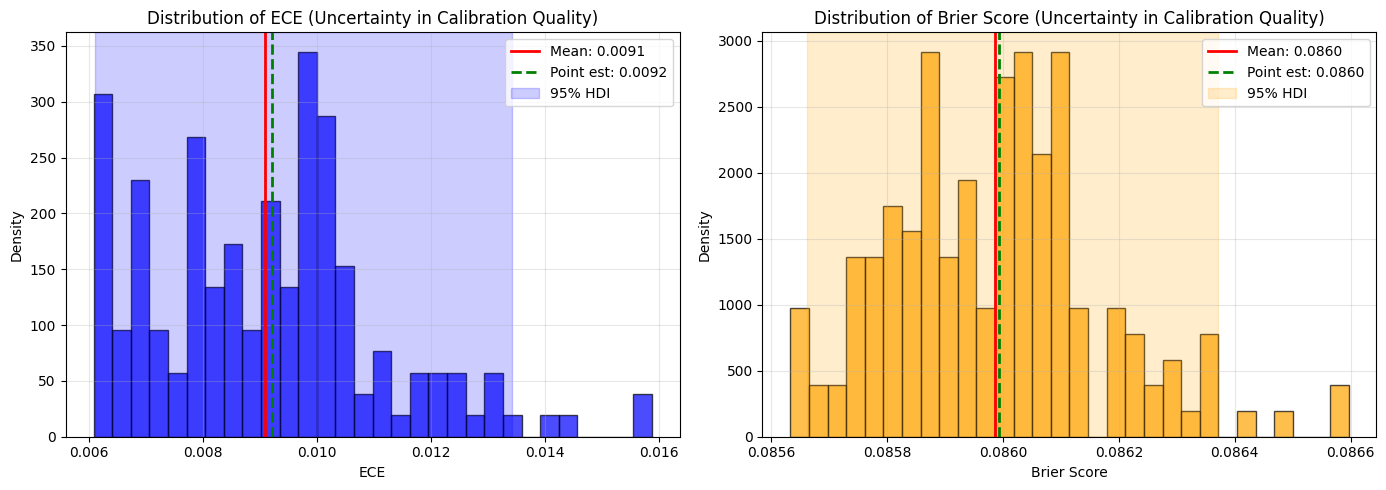


Key Insight:
These distributions show uncertainty in calibration quality itself!
We can now answer: "How confident are we that calibration improved?"
This is impossible with point estimates (L-BFGS).


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(ece_values, bins=30, alpha=0.7, edgecolor='black', color='blue')
axes[0].axvline(ece_point, color='red', linestyle='--', linewidth=2, label=f'Point estimate: {ece_point:.4f}')
axes[0].axvline(ece_mean, color='green', linestyle='--', linewidth=2, label=f'Bayesian mean: {ece_mean:.4f}')
axes[0].fill_between([ece_hdi_lower, ece_hdi_upper], [0, 0], [axes[0].get_ylim()[1], axes[0].get_ylim()[1]], 
                     alpha=0.3, color='blue', label='95% HDI')
axes[0].set_xlabel('ECE')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of ECE Across Posterior Samples')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[1].hist(brier_values, bins=30, alpha=0.7, edgecolor='black', color='green')
axes[1].axvline(brier_point, color='red', linestyle='--', linewidth=2, label=f'Point estimate: {brier_point:.4f}')
axes[1].axvline(brier_mean, color='blue', linestyle='--', linewidth=2, label=f'Bayesian mean: {brier_mean:.4f}')
axes[1].fill_between([brier_hdi_lower, brier_hdi_upper], [0, 0], [axes[1].get_ylim()[1], axes[1].get_ylim()[1]], 
                     alpha=0.3, color='green', label='95% HDI')
axes[1].set_xlabel('Brier Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Brier Score Across Posterior Samples')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../latex/figures/ece-brier_Score_dist.png', dpi=300, bbox_inches='tight')
plt.show()
print('\nKey Insight:')
print('These distributions show uncertainty in calibration quality itself!')
print('We can now answer: "How confident are we that calibration improved?"')
print('This is impossible with point estimates (L-BFGS).')

In [ ]:
print('='*60)
print('COMPARISON WITH BASELINE METHODS')
print('='*60)
baseline_results = np.load('./data/results/baseline_results.npy', allow_pickle=True).item()
baseline = baseline_results['results']
print(f'\n{"Method":<30} {"ECE":<18} {"Brier Score":<18} {"Uncertainty":<25}')
print('-'*91)
print(f'{"Uncalibrated":<30} {baseline["Uncalibrated"]["ece"]:<18.4f} {baseline["Uncalibrated"]["brier"]:<18.4f} {"N/A":<25}')
print(f'{"Temperature Scaling (L-BFGS)":<30} {baseline["Temperature Scaling"]["ece"]:<18.4f} {baseline["Temperature Scaling"]["brier"]:<18.4f} {"N/A":<25}')
print(f'{"Bayesian (mean)":<30} {ece_mean:<18.4f} {brier_mean:<18.4f} {f"[{ece_hdi_lower:.4f}, {ece_hdi_upper:.4f}]":<25}')
print('\nKey advantage of Bayesian:')
print('  - L-BFGS: Single ECE value (0.0094)')
print(f'  - Bayesian: ECE distribution with 95% HDI [{ece_hdi_lower:.4f}, {ece_hdi_upper:.4f}]')
print('  - We can quantify uncertainty in calibration improvement!')

COMPARISON WITH BASELINE METHODS

Method                         ECE             Brier Score     Uncertainty         
--------------------------------------------------------------------------------
Uncalibrated                   0.0386          0.0943          N/A                 
Temperature Scaling (L-BFGS)   0.0094          0.0860          N/A                 
Bayesian (mean)                0.0091          0.0860          [0.0061, 0.0134]    

Key advantage of Bayesian:
  - L-BFGS: Single ECE value (0.0094)
  - Bayesian: ECE distribution with 95% HDI [0.0061, 0.0134]
  - We can quantify uncertainty in calibration improvement!


In [ ]:
print('='*60)
print('SAVING METRIC RESULTS')
print('='*60)
os.makedirs('./data/results', exist_ok=True)
metric_results = {
    'ece_mean': ece_mean,
    'ece_std': ece_std,
    'ece_hdi': [ece_hdi_lower, ece_hdi_upper],
    'brier_mean': brier_mean,
    'brier_std': brier_std,
    'brier_hdi': [brier_hdi_lower, brier_hdi_upper]
}
np.save('./data/results/metric_uncertainty_results.npy', metric_results, allow_pickle=True)
print('✓ Metric uncertainty results saved')
print('\nNext step: Run Notebook 7 for Active Learning and OOD Analysis')

SAVING METRIC RESULTS
✓ Metric uncertainty results saved

Next step: Run Notebook 7 for Active Learning and OOD Analysis
